In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt


class WorldEnv:
    def __init__(self):
        self.distance_threshold = 0.15
        self.action_bound = 1

    def reset(self):  # 重置环境
        # 生成一个目标状态, 坐标范围是[3.5～4.5, 3.5～4.5]
        self.goal = np.array(
            [4 + random.uniform(-0.5, 0.5), 4 + random.uniform(-0.5, 0.5)])
        self.state = np.array([0, 0])  # 初始状态
        self.count = 0
        return np.hstack((self.state, self.goal))

    def step(self, action):
        action = np.clip(action, -self.action_bound, self.action_bound)
        x = max(0, min(5, self.state[0] + action[0]))
        y = max(0, min(5, self.state[1] + action[1]))
        self.state = np.array([x, y])
        self.count += 1

        dis = np.sqrt(np.sum(np.square(self.state - self.goal)))
        reward = -1.0 if dis > self.distance_threshold else 0
        if dis <= self.distance_threshold or self.count == 50:
            done = True
        else:
            done = False

        return np.hstack((self.state, self.goal)), reward, done

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return torch.tanh(self.fc3(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc2(F.relu(self.fc1(cat))))
        return self.fc3(x)

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, sigma, tau, gamma, device):
        self.action_dim = action_dim
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim,
                               action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim,
                                      action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim,
                                       action_dim).to(device)
        # 初始化目标价值网络并使其参数和价值网络一样
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并使其参数和策略网络一样
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_bound = action_bound
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).detach().cpu().numpy()[0]
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states,
                                           self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        # MSE损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 策略网络就是为了使Q值最大化
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [4]:
class Trajectory:
    ''' 用来记录一条完整轨迹 '''
    def __init__(self, init_state):
        self.states = [init_state]
        self.actions = []
        self.rewards = []
        self.dones = []
        self.length = 0

    def store_step(self, action, state, reward, done):
        self.actions.append(action)
        self.states.append(state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.length += 1


class ReplayBuffer_Trajectory:
    ''' 存储轨迹的经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add_trajectory(self, trajectory):
        self.buffer.append(trajectory)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size, use_her, dis_threshold=0.15, her_ratio=0.8):
        batch = dict(states=[],
                     actions=[],
                     next_states=[],
                     rewards=[],
                     dones=[])
        for _ in range(batch_size):
            traj = random.sample(self.buffer, 1)[0]
            step_state = np.random.randint(traj.length)
            state = traj.states[step_state]
            next_state = traj.states[step_state + 1]
            action = traj.actions[step_state]
            reward = traj.rewards[step_state]
            done = traj.dones[step_state]

            if use_her and np.random.uniform() <= her_ratio:
                step_goal = np.random.randint(step_state + 1, traj.length + 1)
                goal = traj.states[step_goal][:2]  # 使用HER算法的future方案设置目标
                dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))
                reward = -1.0 if dis > dis_threshold else 0
                done = False if dis > dis_threshold else True
                state = np.hstack((state[:2], goal))
                next_state = np.hstack((next_state[:2], goal))

            batch['states'].append(state)
            batch['next_states'].append(next_state)
            batch['actions'].append(action)
            batch['rewards'].append(reward)
            batch['dones'].append(done)

        batch['states'] = np.array(batch['states'])
        batch['next_states'] = np.array(batch['next_states'])
        batch['actions'] = np.array(batch['actions'])
        return batch

Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]/var/folders/ns/snlbpbln0w9fk_x7wpkkdxyh0000gn/T/ipykernel_20365/3560096994.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 200/200 [00:13<00:00, 14.41it/s, episode=2000, return=-4.000]


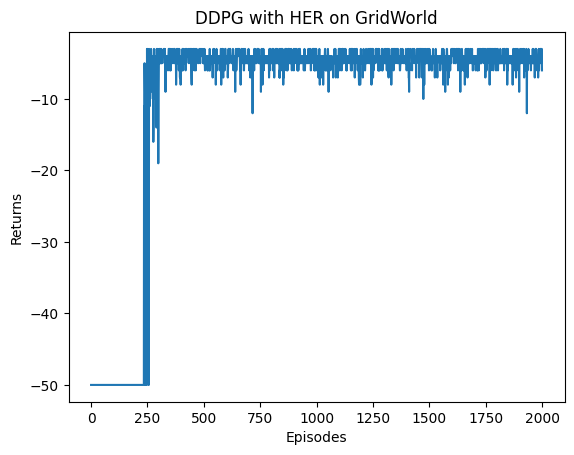

In [5]:
actor_lr = 1e-3
critic_lr = 1e-3
hidden_dim = 128
state_dim = 4
action_dim = 2
action_bound = 1
sigma = 0.1
tau = 0.005
gamma = 0.98
num_episodes = 2000
n_train = 20
batch_size = 256
minimal_episodes = 200
buffer_size = 10000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    transition_dict = replay_buffer.sample(batch_size, True)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG with HER on {}'.format('GridWorld'))
plt.show()

# Iteration 0: 100%|██████████| 200/200 [00:03<00:00, 58.91it/s, episode=200,
# return=-50.000]
# Iteration 1: 100%|██████████| 200/200 [01:17<00:00,  2.56it/s, episode=400,
# return=-4.200]
# Iteration 2: 100%|██████████| 200/200 [01:18<00:00,  2.56it/s, episode=600,
# return=-4.700]
# Iteration 3: 100%|██████████| 200/200 [01:18<00:00,  2.56it/s, episode=800,
# return=-4.300]
# Iteration 4: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s, episode=1000,
# return=-3.800]
# Iteration 5: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s, episode=1200,
# return=-4.800]
# Iteration 6: 100%|██████████| 200/200 [01:18<00:00,  2.54it/s, episode=1400,
# return=-4.500]
# Iteration 7: 100%|██████████| 200/200 [01:19<00:00,  2.52it/s, episode=1600,
# return=-4.400]
# Iteration 8: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s, episode=1800,
# return=-4.200]
# Iteration 9: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s, episode=2000,
# return=-4.300]

Iteration 9: 100%|██████████| 200/200 [00:08<00:00, 23.17it/s, episode=2000, return=-45.300]


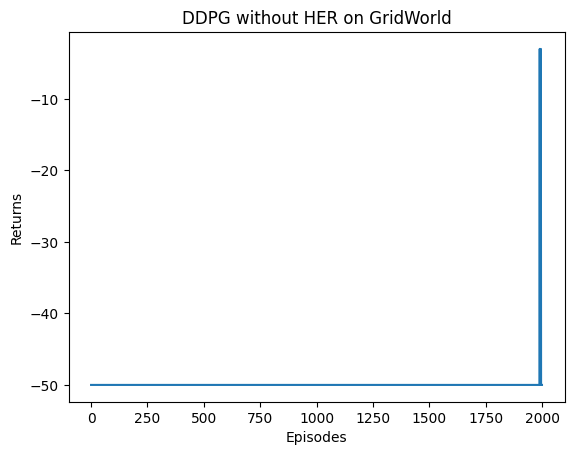

In [6]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    # 和使用HER训练的唯一区别
                    transition_dict = replay_buffer.sample(batch_size, False)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG without HER on {}'.format('GridWorld'))
plt.show()

# Iteration 0: 100%|██████████| 200/200 [00:03<00:00, 62.82it/s, episode=200,
# return=-50.000]
# Iteration 1: 100%|██████████| 200/200 [00:39<00:00,  5.01it/s, episode=400,
# return=-50.000]
# Iteration 2: 100%|██████████| 200/200 [00:41<00:00,  4.83it/s, episode=600,
# return=-50.000]
# Iteration 3: 100%|██████████| 200/200 [00:41<00:00,  4.82it/s, episode=800,
# return=-50.000]
# Iteration 4: 100%|██████████| 200/200 [00:41<00:00,  4.81it/s, episode=1000,
# return=-50.000]
# Iteration 5: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s, episode=1200,
# return=-50.000]
# Iteration 6: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, episode=1400,
# return=-45.500]
# Iteration 7: 100%|██████████| 200/200 [00:41<00:00,  4.80it/s, episode=1600,
# return=-42.600]
# Iteration 8: 100%|██████████| 200/200 [00:40<00:00,  4.92it/s, episode=1800,
# return=-4.800]
# Iteration 9: 100%|██████████| 200/200 [00:40<00:00,  4.99it/s, episode=2000,
# return=-4.800]